# Feature selection for detection
Regression has to be done by ion (mol+adduct), because we don't have a good way to combine intensities across adducts.

In [1]:
from pathlib import Path
import scipy.stats
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
plt.style.use('dark_background')

plots_dir = Path.cwd() / "../plots"
results_dir = Path.cwd() / "../results/detection"


In [2]:
filenames = {
    "fingerprints": "results_fingerprints_feat_selection.csv",
    "mol": "results_mol_feat_selection.csv",
    # "random_feat": "regr_results_random_feat.csv",
    # "no_feat": "regr_results_no_feat.csv",
}

INCLUDE_NOT_DETECTED_IN_SCORE = True

In [8]:
# compute Spearman's/Pearson's correlation and mean squared error for each matrix/polarity/regressor
score_cols = ['not_det_precision', 'not_det_recall', 'not_det_f1', 'not_detected',
                                            'det_precision', 'det_recall', 'det_f1', 'detected', 'macro_avg_f1_score']
models_results = pd.DataFrame()
model_metrics = pd.DataFrame(columns = ['train_setup', 'matrix', 'polarity', 'model_type', 'feat_sel_method', 'quantile'] + score_cols)
model_metrics_global = pd.DataFrame(columns = ['train_setup', 'model_type', 'feat_sel_method', 'quantile'] + score_cols)
counter = 0
counter_global = 0

for train_setup in filenames:
    result_filename = filenames[train_setup]
    loc_models_results = pd.read_csv(results_dir / result_filename, index_col = 0)
    loc_models_results = loc_models_results.rename(columns={'Matrix short': 'matrix',
                                                          'Polarity': 'polarity'})



    for (matrix, polarity, model_type, feat_sel_met, quantile), rows in loc_models_results.groupby(['matrix', 'polarity', 'classifier', 'feat_sel_method', 'feat_sel_quantile']):
        # remove zero intensity molecules if needed (optional)

        clf_report = classification_report(rows.observed_value, rows.prediction, output_dict = True, zero_division=0)
        if rows.observed_value.max() == 0:
            print("no detection!")
        result_row = [train_setup, matrix, polarity, model_type, feat_sel_met, round(quantile*6),
                                          clf_report['0']['precision'], clf_report['0']['recall'],
                                          clf_report['0']['f1-score'], clf_report['0']['support'],
                                          clf_report['1']['precision'], clf_report['1']['recall'],
                                          clf_report['1']['f1-score'], clf_report['1']['support'],
                                          clf_report['macro avg']['f1-score']
                                          ]
        model_metrics.loc[counter] = result_row
        counter += 1

    loc_models_results["train_setup"] = train_setup
    models_results = pd.concat([models_results, loc_models_results])

    # Compute global scores:
    for (model_type, feat_sel_met, quantile), rows in loc_models_results.groupby(['classifier', 'feat_sel_method', 'feat_sel_quantile']):
        clf_report = classification_report(rows.observed_value, rows.prediction, output_dict = True, zero_division=0)
        if rows.observed_value.max() == 0:
            print("no detection!")
        model_metrics_global.loc[counter_global] = [train_setup, model_type, feat_sel_met, round(quantile*6),
                                          clf_report['0']['precision'], clf_report['0']['recall'],
                                          clf_report['0']['f1-score'], clf_report['0']['support'],
                                          clf_report['1']['precision'], clf_report['1']['recall'],
                                          clf_report['1']['f1-score'], clf_report['1']['support'],
                                          clf_report['macro avg']['f1-score']
                                          ]
        counter_global += 1


In [14]:
model_metrics[model_metrics.feat_sel_method == "kendall"].feat_sel_method = "kendall-F"

/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_95006/4131410002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_metrics[model_metrics.feat_sel_method == "kendall"].feat_sel_method = "kendall-F"


High quantile means few features (zero == all features are used). In the


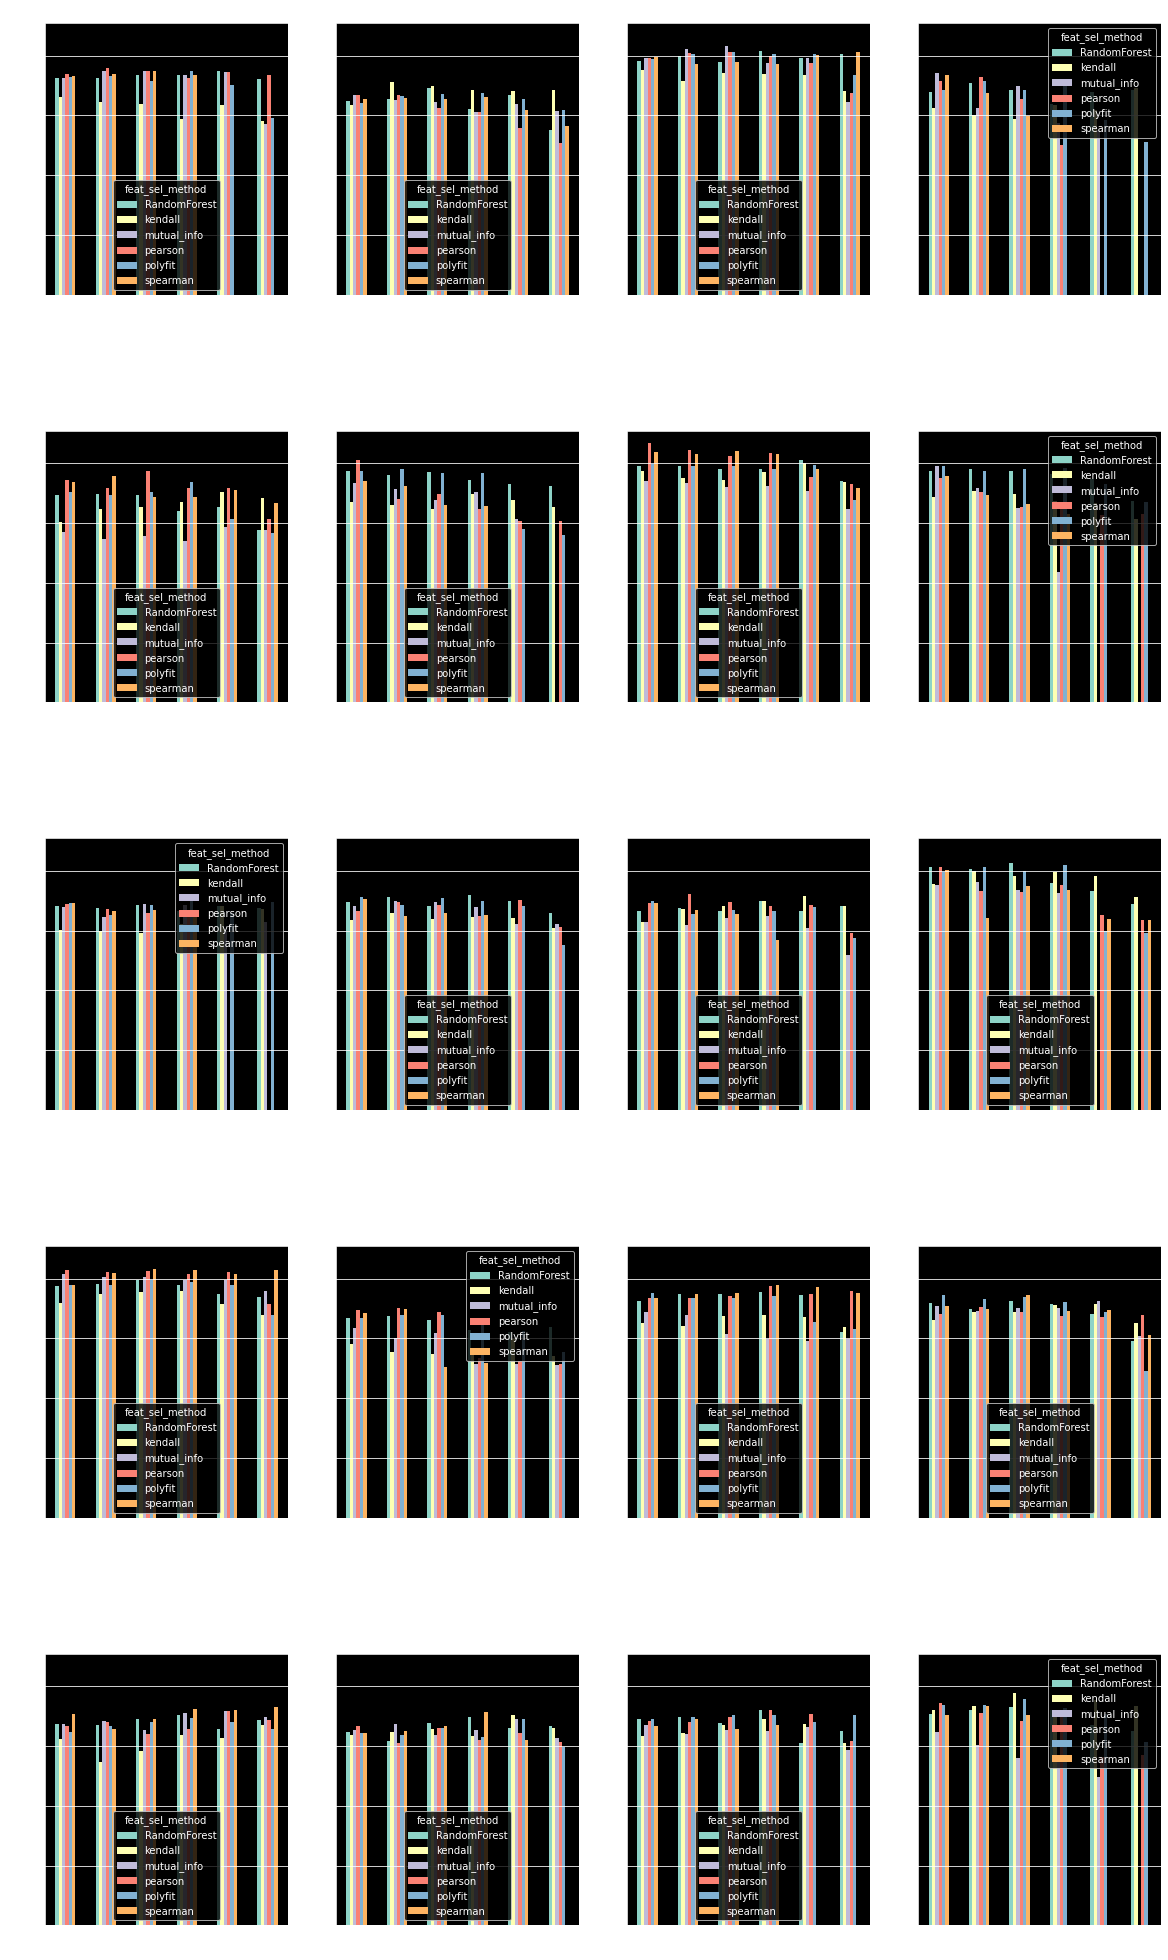

In [11]:
fig, axes = plt.subplots(ncols=4,nrows=5, sharey=True, figsize= (20, 35))
ax_list = axes.flat

metric = "macro_avg_f1_score"

i = 0
for (matrix, polarity), rows in model_metrics.groupby(['matrix', 'polarity']):
    # nb_obs = rows['non-zero obs'].drop_duplicates().values[0]
    nb_obs = rows['detected'].drop_duplicates().values[0]
    rows = rows.set_index(['quantile', "feat_sel_method"], drop = True).sort_values( by = ["feat_sel_method", metric])
    rows = rows.unstack("feat_sel_method")
    rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity} ({nb_obs})")
    ax_list[i].set_ylabel(metric)
    ax_list[i].grid(axis='y')
    # TODO: position legend
    # if i != 0:
    #     ax_list[i].get_legend().set_visible(False)
    i+=1

plt.subplots_adjust(hspace=0.5)
plt.show()


For each matrix, get the max "Spearman's R" achieved, and compute difference between this max value and
 the value achieved by each model (compare bars of same colors, not across colors). MLP seems to be the best in all setups:

<AxesSubplot:xlabel='quantile'>

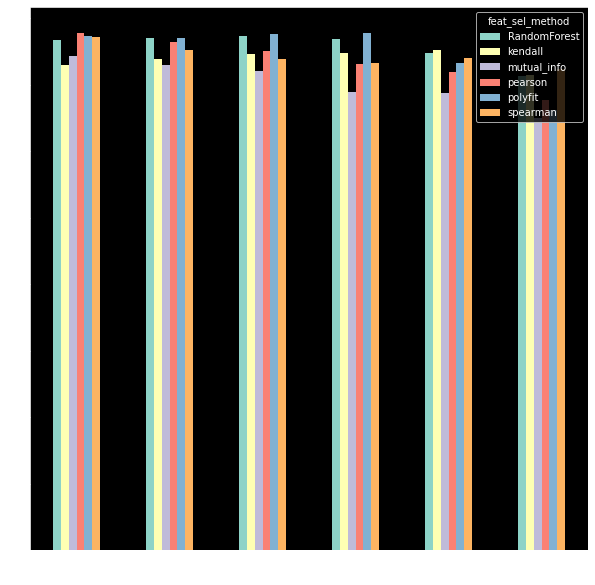

In [12]:
model_metrics_global.set_index(['quantile', "feat_sel_method"], drop=True)[metric].unstack("feat_sel_method").plot.bar(figsize=(10,10))

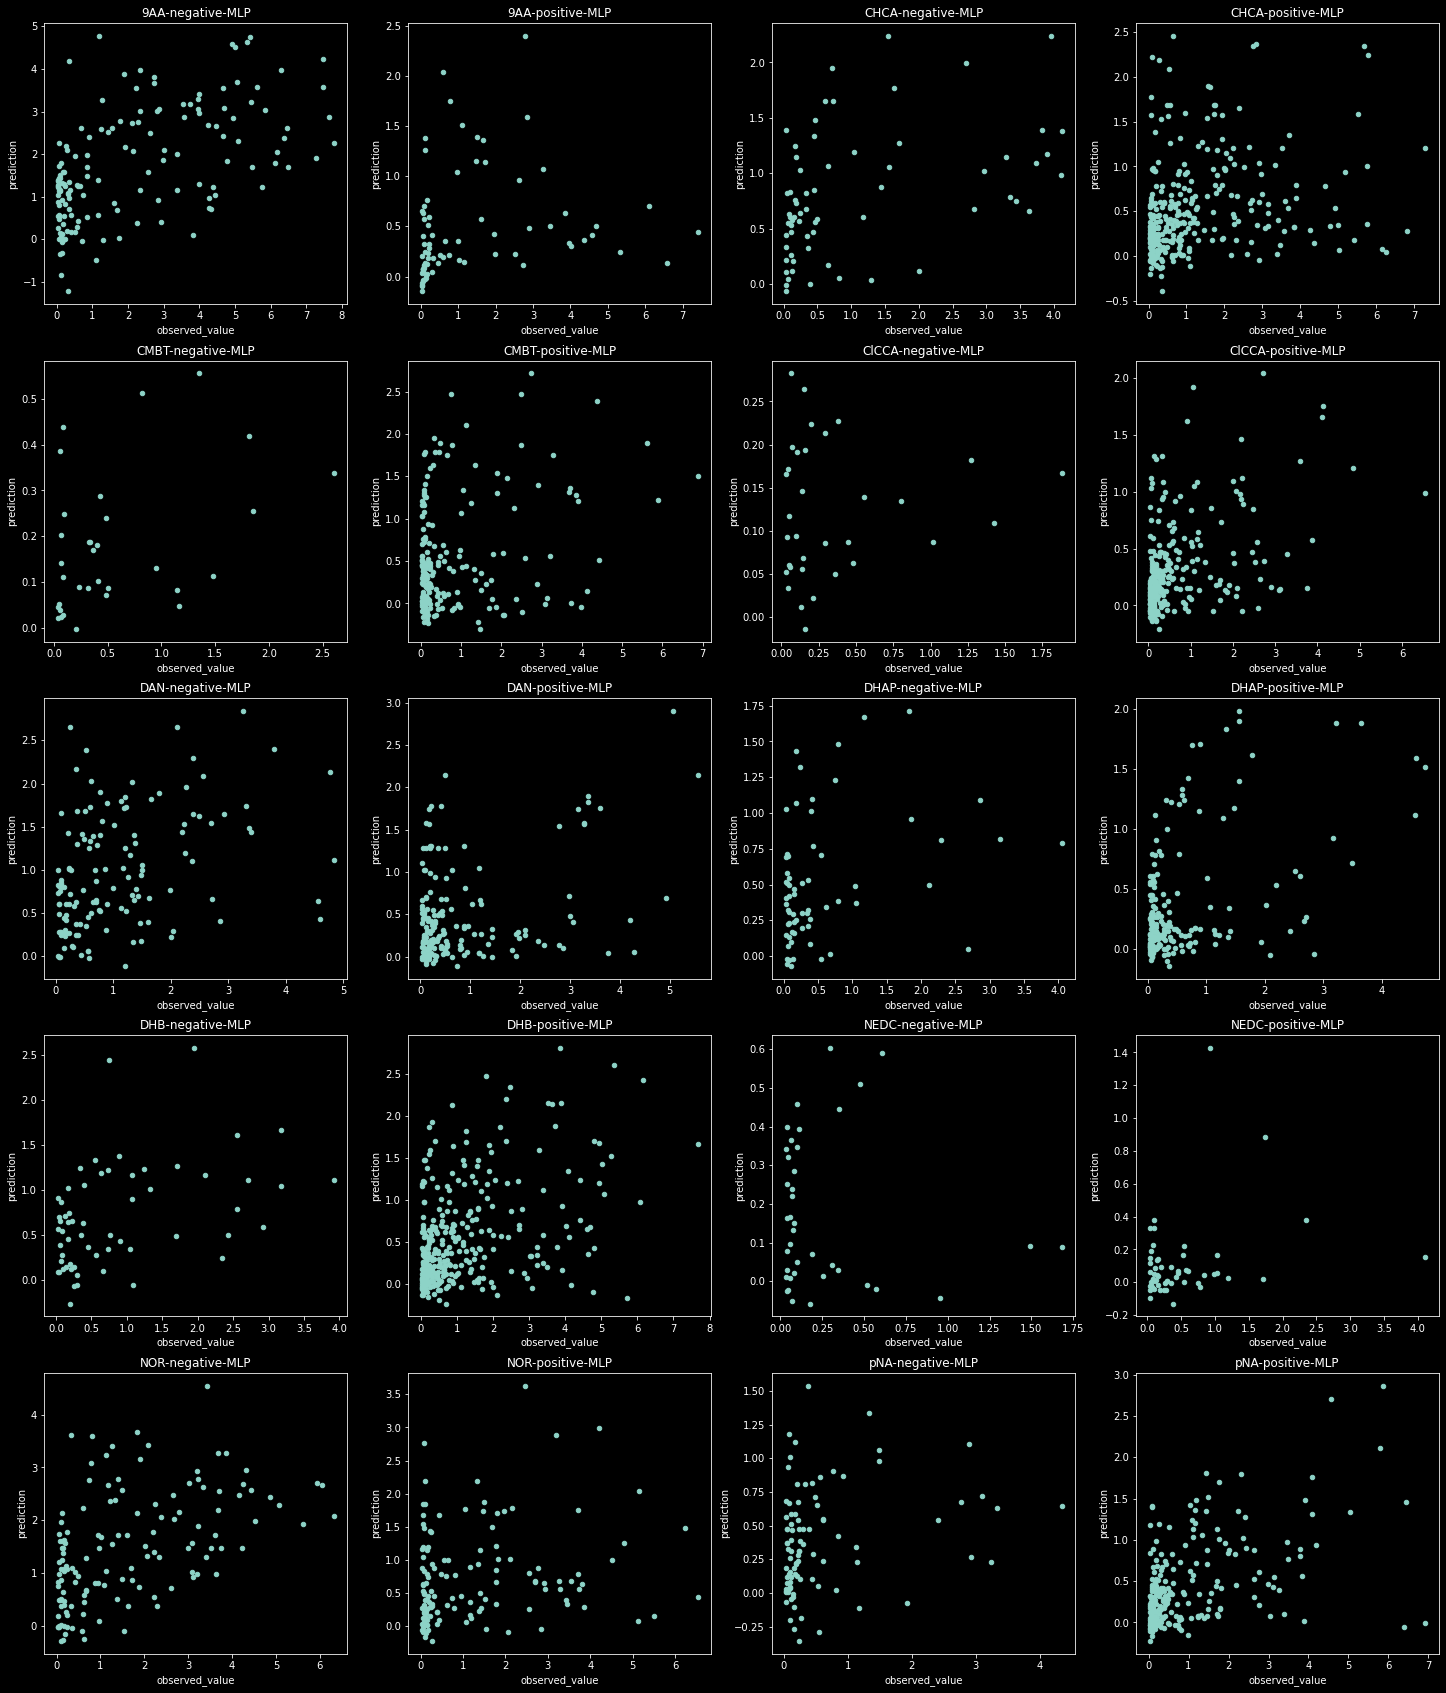

In [59]:
# fig, axes = plt.subplots(ncols=4,nrows=5, figsize= (25, 30))
# ax_list = axes.flat
#
# regressor = "MLP"
# train_setup = "all_feat"
#
# i = 0
# for (matrix, polarity), rows in models_results.groupby(['matrix', 'polarity']):
#     rows = rows[rows["train_setup"] == train_setup]
#     if not INCLUDE_NOT_DETECTED_IN_SCORE:
#         rows = rows[rows["observed_value"] > 0]
#     rows[rows.regressor == regressor].plot.scatter(x = 'observed_value', y= 'prediction',
#                                                    ax = ax_list[i], title=f"{matrix}-{polarity}-{regressor}")
#     i+=1
#
# plt.subplots_adjust(hspace=0.2, wspace=0.2)
# plt.show()